# Julia Quickstart

**John Stachurski** 
October 2023

This is a super quick introduction to Julia for people who already have programming experience in MATLAB, Python, etc.  

I'll use `PyPlot` for the plots because it is an interface to Matplotlib, which is a Python plotting library I'm very familiar with.  You can try changing the code to use an alternative Julia plotting library if you wish.

## Notes for Colab users

You will need to uncomment the first line of the following cell (remove `#`) and run it.



In [1]:
#%%shell
set -e

JULIA_VERSION="1.9.3" 
JULIA_PACKAGES="IJulia BenchmarkTools PyPlot Random Distributions"
JULIA_NUM_THREADS=2


if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz 
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) and then"
  echo "jump to the next section."
fi

LoadError: UndefVarError: `set` not defined

## Notes for local installs

If you wish to continue with `PyPlot`, you should install [Anaconda Python](https://www.anaconda.com/download) on your machine first [and do some basic checks](https://python-programming.quantecon.org/getting_started.html).


This notebook requires the following packages: `IJulia, PyPlot, Random, Distributions, BenchmarkTools`

If these packages are not installed, open [the Julia REPL](https://docs.julialang.org/en/v1/manual/getting-started/) and type `]`.

This should drop you into the package manager prompt, where you can type

`add PyPlot`

etc.  Note that you also need `IJulia` as well to run Jupyter Notebooks / Lab with a Julia kernel.

When you are done, exit the terminal, return to this notebook and restart the kernel.



## Rule 1: Don't code in the notebook

Here's a note for the future --- but not today.

Find yourself a good code editor such as VS Code or, if you believe (like me) that suffering makes you stronger, [neovim](https://neovim.io/).

Now write yourself some `jl` files and run them from the text editor.

- Yes, it will take time to get used to this workflow
- but it's an increasing returns technology

If you like the notebooks for communicating results (as I do), then use the notebook to call functions that are written in `jl` files.

But putting that aside for now...

## Imports

In [2]:
using PyPlot, Random, Distributions, BenchmarkTools

## Syntax 

Let's look at some examples that highlight Julia syntax.

### Example 1

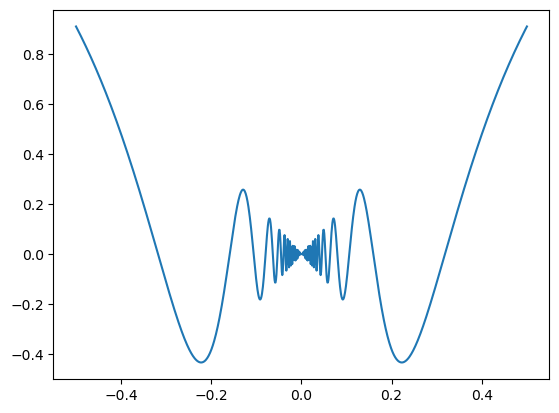

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3488f98a10>

In [3]:
f(x) = 2x * sin(1/x)                  # simple function definition
x_grid = LinRange(-.5, .5, 1_000)     # even grid
y_grid = f.(x_grid)                   # pointwise map

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid)


### Example 2

In [4]:
"""
Generate a draw from the Binomial(n, p) distribution, which counts
the number of successes, with probability p, in n independent trials.

"""
function binomial_draw(n, p)
    counter = 0
    for i in 1:n
        U = rand()        # uniform(0,1) draw
        if U < p          # with probability p
            counter += 1
        end
    end
    return counter
end

binomial_draw

Let's generate some draws and plot a histogram.

In [5]:
n, p = 40, 0.6
seed = 1234
num_draws = 10_000_000

Random.seed!(seed)
draws = [binomial_draw(n, p) for i in 1:num_draws];
draws[1:5]

5-element Vector{Int64}:
 23
 24
 26
 19
 21

In [6]:
mean(draws) - n * p # should be close to zero

-5.699999999109195e-6

In [7]:
var(draws) - n * p * (1 - p) # should be close to zero

-0.0005595400884459423

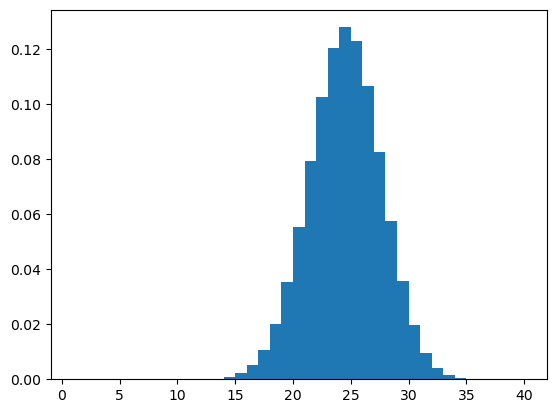

In [8]:
fig, ax = plt.subplots()
ax.hist(draws, bins=1:n, density=true);

Incidentally, binomial draws can be generated more easily using `Distributions`

In [9]:
b = Binomial(n, p)
draws = rand(b, num_draws);

## Variables and types

### floats, ints, etc

In [10]:
x = 1.0
typeof(x)

Float64

In [11]:
typeof(x) <: Number

true

In [12]:
typeof(x) <: String

false

In [13]:
using Base: show_supertypes
show_supertypes(typeof(x))

Float64 <: AbstractFloat <: Real <: Number <: Any

In [14]:
y = 2
typeof(y)

Int64

In [15]:
show_supertypes(typeof(y))

Int64 <: Signed <: Integer <: Real <: Number <: Any

In [16]:
y = convert(Int32, y)

2

In [17]:
typeof(y)

Int32

In [18]:
z = "foobar"

"foobar"

In [19]:
show_supertypes(typeof(z))

String <: AbstractString <: Any

Automatic type promotion

In [20]:
z = x + y   # Int + Float

3.0

In [21]:
typeof(z)

Float64

### Container types

#### Tuples

In [22]:
vars = 10, 1.0, "foobar"   # vars = a, b, c  or  vars = (a, b, c)

(10, 1.0, "foobar")

In [23]:
typeof(vars)

Tuple{Int64, Float64, String}

In [24]:
a, b, c = vars;  # tuple unpacking

In [25]:
a

10

In [26]:
vars[1] = "foo"  # tuples are immutable

LoadError: MethodError: no method matching setindex!(::Tuple{Int64, Float64, String}, ::String, ::Int64)

#### Arrays

In [27]:
vars = ["foo", 1.0, "foobar"]

3-element Vector{Any}:
  "foo"
 1.0
  "foobar"

In [28]:
vars[1] = "jstac"

"jstac"

In [29]:
vars

3-element Vector{Any}:
  "jstac"
 1.0
  "foobar"

Note that the element type is `Any` because we are storing mixed types in one array:

In [30]:
eltype(vars)

Any

Such arrays will not interact well with high performance code.

In numerical work we typically ensure that all elements have the same concrete type.

In [31]:
z = zeros(3)

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [32]:
eltype(z)

Float64

In [33]:
z = zeros(Int32, 3)

3-element Vector{Int32}:
 0
 0
 0

In [34]:
eltype(z)

Int32

In [35]:
z = Array{Float64}(undef, 3)   # "empty" array

3-element Vector{Float64}:
 6.9102115697865e-310
 6.9102115697881e-310
 6.91029688161076e-310

#### NamedTuples

NamedTyples are built into Julia's base language and provide an excellent container type for storing parameters and constant arrays used in a given model.

In [36]:
z = (; a=10, b=2.0, c="foobar")  # building a NamedTuple

(a = 10, b = 2.0, c = "foobar")

In [37]:
typeof(z)

NamedTuple{(:a, :b, :c), Tuple{Int64, Float64, String}}

In [38]:
z.a

10

In [39]:
z.b

2.0

In [40]:
z.b = 12

LoadError: setfield!: immutable struct of type NamedTuple cannot be changed

In [41]:
(; c, b) = z   # unpacking by name

(a = 10, b = 2.0, c = "foobar")

In [42]:
b

2.0

In [43]:
c

"foobar"

#### Concrete vs abstract arrays

In [44]:
array_1 = [i * 0.001 for i in 0:1000];

In [45]:
eltype(array_1)

Float64

In [46]:
minimum(array_1), maximum(array_1)

(0.0, 1.0)

In [47]:
show_supertypes(typeof(array_1))

Vector{Float64} <: DenseVector{Float64} <: AbstractVector{Float64} <: Any

The following `LinRange` object looks similar.

In [48]:
array_2 = LinRange(0, 1, 1001)   # memory efficient linear grid

1001-element LinRange{Float64, Int64}:
 0.0, 0.001, 0.002, 0.003, 0.004, 0.005, …, 0.996, 0.997, 0.998, 0.999, 1.0

In [49]:
eltype(array_2)

Float64

In [50]:
show_supertypes(typeof(array_2))

LinRange{Float64, Int64} <: AbstractRange{Float64} <: AbstractVector{Float64} <: Any

In [51]:
isapprox(array_1, array_2)

true

But look at memory storage.

In [52]:
varinfo(r"array_1")

| name    |      size | summary                      |
|:------- | ---------:|:---------------------------- |
| array_1 | 7.859 KiB | 1001-element Vector{Float64} |


In [53]:
varinfo(r"array_2")

| name    |     size | summary                               |
|:------- | --------:|:------------------------------------- |
| array_2 | 32 bytes | 1001-element LinRange{Float64, Int64} |


The `LinRange` type is just storing instructions to build the array, not the actual data.

In [54]:
collect_data = collect(array_2);

In [55]:
varinfo(r"collect_data")

| name         |      size | summary                      |
|:------------ | ---------:|:---------------------------- |
| collect_data | 7.859 KiB | 1001-element Vector{Float64} |


## Names and data

In the code

In [56]:
a = randn(3)

3-element Vector{Float64}:
 -0.00688421178617798
  1.9487798744166431
  2.0414786361006882

the name `a` is bound to the `Vector{Float64}` object created in memory

If we now write

In [57]:
b = a;

then the name `b` is bound to the same object --- the data is **not** copied.

In [58]:
b

3-element Vector{Float64}:
 -0.00688421178617798
  1.9487798744166431
  2.0414786361006882

In [59]:
pointer(b)

Ptr{Float64} @0x00007f3511d7fe20

In [60]:
pointer(a)

Ptr{Float64} @0x00007f3511d7fe20

This means that mutating `b` also mutates `a`

In [61]:
b[1] = 42.0

42.0

In [62]:
b

3-element Vector{Float64}:
 42.0
  1.9487798744166431
  2.0414786361006882

In [63]:
a

3-element Vector{Float64}:
 42.0
  1.9487798744166431
  2.0414786361006882

If you want a separate copy of an array, use `copy`

In [64]:
c = copy(a);

In [65]:
c

3-element Vector{Float64}:
 42.0
  1.9487798744166431
  2.0414786361006882

In [66]:
pointer(c)

Ptr{Float64} @0x00007f34af0984f0

In [67]:
pointer(a)

Ptr{Float64} @0x00007f3511d7fe20

Since `c` and `a` are bound to different data, I can mutate one without changing the other.

In [68]:
c[:] .= 10.0 ;    

In [69]:
c

3-element Vector{Float64}:
 10.0
 10.0
 10.0

In [70]:
a

3-element Vector{Float64}:
 42.0
  1.9487798744166431
  2.0414786361006882

## Flow Control

### Basics

In [71]:
vals = randn(3)

3-element Vector{Float64}:
 -0.5158701668423166
 -0.6073060790723412
 -1.2109392762722035

In [72]:
for (i, v) in enumerate(vals)
    if v < 0
        v = -v
    end
    println("absolute value of element $i is $v")
end

absolute value of element 1 is 0.5158701668423166
absolute value of element 2 is 0.6073060790723412
absolute value of element 3 is 1.2109392762722035


In [73]:
vals

3-element Vector{Float64}:
 -0.5158701668423166
 -0.6073060790723412
 -1.2109392762722035

### Functions

#### Basic syntax

In [74]:
"""
This is the docstring of the function.

The function has 

    one positional arg a
    one positional arg with default value b
    two keyword args with defaults c, d
"""
function f(a, b=10; c=20, d=30) 
    return a + b + c + b
end

f

In [75]:
f(10)

50

In [76]:
f(10, b=100)  # wrong because b is not a keyword argument

LoadError: MethodError: no method matching f(::Int64, ::Int64; b::Int64)

[0mClosest candidates are:
[0m  f(::Any, ::Any; c, d)[91m got unsupported keyword argument "b"[39m
[0m[90m   @[39m [35mMain[39m [90m[4mIn[74]:10[24m[39m
[0m  f(::Any)[91m got unsupported keyword argument "b"[39m
[0m[90m   @[39m [35mMain[39m [90m[4mIn[74]:10[24m[39m


In [77]:
f(10, 100)   # calls with a=10 and b=100

230

In [78]:
f(10, d=100)  # OK because d is a keyword argument

50

#### A more complex example

The next example illustrates

* passing a function to a function
* multiple dispatch

In [79]:
function successive_approximation(f, x0::Real; max_iter=100_000, tol=1e-6)
    println("Applying successive approximation starting at scalar $x0")
    error = Inf
    i = 0
    x = x0
    while error > tol && i < max_iter
        x_new = f(x)
        error = abs.(x_new - x)
        x = x_new
        i += 1
    end
    return x
end

successive_approximation (generic function with 1 method)

In [80]:
function successive_approximation(f, x0::Vector; max_iter=100_000, tol=1e-6)
    println("Applying successive approximation starting at vector $x0")
    error = Inf
    i = 0
    x = x0
    while error > tol && i < max_iter
        x_new = f(x)
        error = maximum(abs.(x_new - x))   # added maximum 
        x = x_new
        i += 1
    end
    return x
end

successive_approximation (generic function with 2 methods)

In [81]:
f(x) = 0.5x
successive_approximation(f, 100)

Applying successive approximation starting at scalar 100


7.450580596923828e-7

In [82]:
A = rand(2, 2) * 0.5

2×2 Matrix{Float64}:
 0.262655  0.0184734
 0.110352  0.359433

In [83]:
f(x) = A * x

f (generic function with 2 methods)

In [84]:
successive_approximation(f, ones(2))

Applying successive approximation starting at vector [1.0, 1.0]


2-element Vector{Float64}:
 4.6185335469166246e-8
 2.8557111296584085e-7

### Local scope

#### Local scope in functions

In [85]:
x = 10
function test()
    x = "foobar"
    print(x)
end

test (generic function with 1 method)

In [86]:
test()

foobar

In [87]:
x  # global x is not affected

10

#### Local scope in loops

Kind of annying if you ask me but...

In [88]:
vals = randn(3)

3-element Vector{Float64}:
  1.036907723030358
 -0.8345363141901403
  1.6984085009275354

Compare

In [89]:
s = 0.0
a = "foo"
for v in vals
    a = abs(v)  # overwrites global a
    s += a
end

In [90]:
a

1.6984085009275354

and

In [91]:
s = 0.0
a = "foo"
for v in vals
    local a = abs(v)  # preserves global a
    s += a
end

In [92]:
a

"foo"

If a global variable does not exist, local variables are destroyed after the loop terminates.

In [93]:
s = 0.0
for v in vals
    new_var = abs(v)  # overwrites global a
    s += new_var
end

In [94]:
new_var

LoadError: UndefVarError: `new_var` not defined

#### Soft scope --- REPL vs Notebook vs Modules

If you try to run code like the cell below as part of a module (copy it to a file `test.jl` and `include("test.jl")` from the REPL) it will probably fail (depending on your Julia version).

When run in this way, the compiler tries to convert variables in soft scope (loops) into locals --- and then complains that `s` doesn't exist in the local scope.

Not one of my favorite Julia features...

In [95]:
"""
Fails in a module.
"""
vals = randn(3)
s = 0.0
a = "foo"
for v in vals
    a = abs(v)  # overwrites global a
    s += a
end

You can get the code to run within a module as follows:

In [96]:
"""
Runs in a module without error.
"""
vals = randn(3)
s = 0.0
a = "foo"
for v in vals
    local a = abs(v)  # overwrites global a
    global s += a
end

Alternatively, you can wrap it in a function:

In [97]:
"""
Runs in a module without error.
"""
function test()
    vals = randn(3)
    s = 0.0
    a = "foo"
    for v in vals
        a = abs(v)  # overwrites global a
        s += a
    end
    print(s)
end
test()

2.8952042418847057

## Performance tips

* all time-critical code should be written in functions
* avoid globals or declare them as const
* preserve type stability of functions

### Minimize globals

Here's a pure function

In [98]:
function f(x, a=1.0)
    y = x + a
    return y
end

f (generic function with 2 methods)

In [99]:
@code_warntype(f(1.0))

MethodInstance for f(::Float64)
  from f(x) @ Main In[98]:1
Arguments
  #self#::Core.Const(f)
  x::Float64
Body::Float64
1 ─ %1 = (#self#)(x, 1.0)::Float64
└──      return %1



In [100]:
@code_llvm(f(1.0))

;  @ In[98]:1 within `f`
define double @julia_f_5059(double %0) #0 {
top:
;  @ In[98]:2 within `f` @ In[98]:2
; ┌ @ float.jl:408 within `+`
   %1 = fadd double %0, 1.000000e+00
; └
;  @ In[98]:2 within `f`
  ret double %1
}


Here's an alternative version that relies on a global variable.

In [101]:
a = 1.0
function g(x)
    y = x + a
    return y
end

g (generic function with 1 method)

In [102]:
@code_warntype(g(1.0))

MethodInstance for g(::Float64)
  from g(x) @ Main In[101]:2
Arguments
  #self#::Core.Const(g)
  x::Float64
Locals
  y::Any
Body::Any
1 ─     (y = x + Main.a)
└──     return y



In [103]:
@code_llvm(g(1.0))

;  @ In[101]:2 within `g`
define nonnull {}* @julia_g_5112(double %0) #0 {
top:
  %1 = alloca [2 x {}*], align 8
  %gcframe4 = alloca [4 x {}*], align 16
  %gcframe4.sub = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe4, i64 0, i64 0
  %.sub = getelementptr inbounds [2 x {}*], [2 x {}*]* %1, i64 0, i64 0
  %2 = bitcast [4 x {}*]* %gcframe4 to i8*
  call void @llvm.memset.p0i8.i32(i8* noundef nonnull align 16 dereferenceable(32) %2, i8 0, i32 32, i1 false)
  %thread_ptr = call i8* asm "movq %fs:0, $0", "=r"() #5
  %ppgcstack_i8 = getelementptr i8, i8* %thread_ptr, i64 -8
  %ppgcstack = bitcast i8* %ppgcstack_i8 to {}****
  %pgcstack = load {}***, {}**** %ppgcstack, align 8
;  @ In[101]:3 within `g`
  %3 = bitcast [4 x {}*]* %gcframe4 to i64*
  store i64 8, i64* %3, align 16
  %4 = getelementptr inbounds [4 x {}*], [4 x {}*]* %gcframe4, i64 0, i64 1
  %5 = bitcast {}** %4 to {}***
  %6 = load {}**, {}*** %pgcstack, align 8
  store {}** %6, {}*** %5, align 8
  %7 = bitcast {}*** %p

### Avoid type instability

A function is type stable if the return type depends on its inputs only through their type, not their values.

In [104]:
function f(x)
    y = x ≤ 0 ? zero(x) : x
    return y
end 

f (generic function with 2 methods)

If I know the input type, then I know the output type.

In [105]:
f(1.0)

1.0

In [106]:
f(1)

1

In [107]:
@code_warntype(f(1.0))

MethodInstance for f(::Float64)
  from f(x) @ Main In[104]:1
Arguments
  #self#::Core.Const(f)
  x::Float64
Locals
  y::Float64
  @_4::Float64
Body::Float64
1 ─      Core.NewvarNode(:(y))
│   %2 = (x ≤ 0)::Bool
└──      goto #3 if not %2
2 ─      (@_4 = Main.zero(x))
└──      goto #4
3 ─      (@_4 = x)
4 ┄      (y = @_4)
└──      return y



Now let's write a function that uses `f`

In [108]:
function test(f, n=1_000_000)
    s = 0.0
    for i in 1:n
        x = randn()
        y = f(x)
        s += y
    end
    return s
end

test (generic function with 3 methods)

In [109]:
test(f)

398918.10313354863

In [110]:
using BenchmarkTools

In [111]:
@btime test(f)

  3.386 ms (0 allocations: 0 bytes)


398798.7901545716

The following function is not type stable.

In [112]:
function bad_f(x)
    if x ≤ 0
        out = 0
    else
        out = x
    end
    return out
end

bad_f (generic function with 1 method)

In [113]:
bad_f(-1.0)

0

In [114]:
bad_f(1.0)

1.0

In [115]:
@code_warntype(bad_f(1.0))

MethodInstance for bad_f(::Float64)
  from bad_f(x) @ Main In[112]:1
Arguments
  #self#::Core.Const(bad_f)
  x::Float64
Locals
  out::Union{Float64, Int64}
Body::Union{Float64, Int64}
1 ─      Core.NewvarNode(:(out))
│   %2 = (x ≤ 0)::Bool
└──      goto #3 if not %2
2 ─      (out = 0)
└──      goto #4
3 ─      (out = x)
4 ┄      return out



In [116]:
@btime test(bad_f)

  12.892 ms (0 allocations: 0 bytes)


398063.011332643

### Don't use structs with non-concrete type

Structs are used to build your own composite types.

This is a rule that you can break sometimes if you are very confident you can anticipate the needs of the compiler --- which is not me, so I stick to the rule.

In [117]:
struct Foo
    a::Real
    b::Real
end

In [118]:
function add_foo(foo::Foo)
    for i in 1:100_000
        c = foo.a + foo.b
    end
end
        

add_foo (generic function with 1 method)

In [119]:
foo = Foo(1, 2.0)

Foo(1, 2.0)

In [120]:
@btime add_foo(foo)

  1.764 ms (100000 allocations: 1.53 MiB)


In [121]:
function add_numbers(a, b)
    for i in 1:100_000
        c = a + b
    end
end

add_numbers (generic function with 1 method)

In [122]:
@btime add_numbers(1, 2.0)

  1.828 ns (0 allocations: 0 bytes)


## Exercise

If $F$ is a CDF and $U$ is uniform on $[0, 1]$, then $X = F^{-1}(U)$ has distribution $F$.

Using this fact and the `rand()` function for uniform draws, generate `1_000_000` draws from the exponential 
distribution $F(x) = 1 - \exp(-\lambda x)$ when $\lambda = 2.0$.  Histogram them and plot them against the density, which you can obtain by differentiating $F$.

With a large number of bins, the histogram and density should be close.

In [123]:
for _ in 1:20 println("solution below 😬") end

solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬
solution below 😬


In [124]:
const λ = 2.0  # breaking my own rule about not using globals

F_inv(q) = (- 1 / λ) * log(1 - q)
f(x) = λ * exp(-λ * x)

f (generic function with 2 methods)

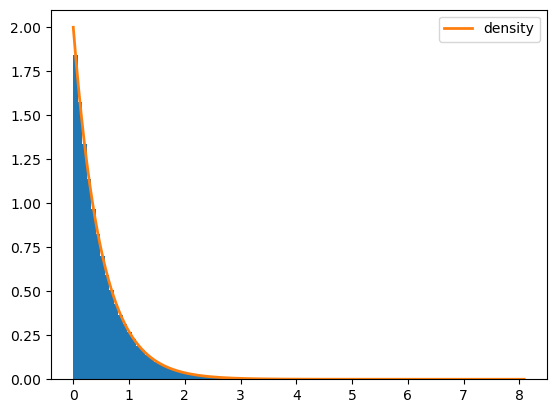

In [125]:
U = rand(1_000_000)
X = F_inv.(U)
x_grid = LinRange(0, maximum(X), 1_000);

fig, ax = plt.subplots()
ax.hist(X, density=true, bins=100)
ax.plot(x_grid, f.(x_grid), lw=2, label="density")
ax.legend();